In [0]:
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('mnist/', one_hot = False)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [0]:
x_treinamento = mnist.train.images
y_treinamento = mnist.train.labels
x_teste = mnist.test.images
y_teste = mnist.test.labels

In [0]:
y_treinamento.shape

(55000,)

In [0]:
y_treinamento = np.asanyarray(y_treinamento, dtype=np.int32)
y_teste = np.asanyarray(y_teste, dtype=np.int32)

In [0]:
x_treinamento

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
x_treinamento[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [0]:
x_treinamento[0]

In [0]:
y_treinamento

array([7, 3, 4, ..., 5, 6, 8], dtype=int32)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(x_treinamento[1].reshape((28, 28)), cmap='gray')
plt.title('Classe:'+str(y_treinamento[1]))

In [0]:
import tensorflow as tf

In [0]:
#@title #Deve-se criar um classificador personalizado para poder usar rede neural convolucional no TensorFlow - Não existe um estimator para esse tipo de função


In [0]:
def cria_rede(features, labels, mode):
  #batch_size, altura, largura, canais
  entrada = tf.reshape(features['X'], [-1, 28, 28, 1])
  
  #Recebe [batch_size, 28, 28, 1]
  #Retorna [batch_size, 28, 28, 32]
  convolucao1 = tf.layers.conv2d(inputs= entrada, filters=32, kernel_size=[5, 5], activation=tf.nn.relu, padding='same')
  print("conv1: ",convolucao1)
  #Recebe [batch_size, 28, 28, 32]
  #Retorna [batch_size, 14, 14, 32]
  pooling1 = tf.layers.max_pooling2d(inputs = convolucao1,pool_size=[2,2], strides=2)
  print("pooling 1:",pooling1)
  #Recebe [batch_size, 14, 14, 32]
  #Retorna [batch_size, 14, 14, 64]
  convolucao2 = tf.layers.conv2d(inputs= pooling1, filters=64, kernel_size=[5,5], activation=tf.nn.relu, padding='same')
  print("conv 2:",convolucao2)
  #Recebe [batch_size, 14, 14, 64]
  #Retorna [batch_size, 7, 7, 64]
  pooling2 = tf.layers.max_pooling2d(inputs=convolucao2, pool_size=[2, 2], strides=2)
  print("pooling 2:",pooling2)
  #Recebe [batch_size, 7, 7, 64]
  #Retorna [batch_size, 3136]
  flattening = tf.reshape(pooling2,[-1, 7 * 7  * 64])
  print("Flattening: ",flattening)
  # (entrada) 3136 -> (oculta)1024 -> (saida) -> 10
  # Recebe [batch_size, 3136]
  # Retorna 1024
  densa = tf.layers.dense(inputs= flattening, units = 1024, activation=tf.nn.relu)
  print("densa:",densa)
  #dropout
  dropout = tf.layers.dropout(inputs=densa, rate = 0.2, training=mode==tf.estimator.ModeKeys.TRAIN)
  print("dropout: ", dropout)
  #Recebe [batch_size, 1024]
  #Retorna [batch_size, 1024]
  saida = tf.layers.dense(inputs=dropout,units=10)
  print("saida: ",saida)
  previsoes = tf.argmax(saida, axis = 1)
  
  
  
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode = mode, predictions= previsoes)
  
  erro = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=saida)
  print("Erro: ",erro)
  if mode == tf.estimator.ModeKeys.TRAIN:
    otimizador = tf.train.AdamOptimizer(learning_rate=0.0001)
    treinamento = otimizador.minimize(erro, global_step = tf.train.get_global_step())#check point para buscar as informações do treinamento
    return tf.estimator.EstimatorSpec(mode=mode, loss=erro, train_op = treinamento)
  
  if mode == tf.estimator.ModeKeys.EVAL:
    eval_metrics_ops = {'accuracy': tf.metrics.accuracy(labels= labels, predictions = previsoes)}
    return tf.estimator.EstimatorSpec(mode=mode, loss= erro, eval_metric_ops = eval_metrics_ops)
  
  
  


In [0]:
classificador = tf.estimator.Estimator(model_fn = cria_rede)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpozx_zt3v', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f16afeb9048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
y_treinamento

array([7, 3, 4, ..., 5, 6, 8], dtype=int32)

In [0]:
funcao_treinamento = tf.estimator.inputs.numpy_input_fn(x = {'X': x_treinamento}, y = y_treinamento, batch_size=128, num_epochs=None, shuffle=True)
classificador.train(input_fn = funcao_treinamento, steps = 200)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use keras.layers.conv2d instead.
conv1:  Tensor("conv2d/Relu:0", shape=(128, 28, 28, 32), dtype=float32)
Instructions for updating:
Use keras.layers.max_pooling2d instead.
pooling 1: Tensor("max_pooling2d/MaxPool:0", shape=(128, 14, 14, 32), dtype=float32)
conv 2: Tensor("conv2d_1/Relu:0", shape=(128, 14, 14, 64), dtype=float32)
pooling 2: Tensor("max_pooling2d_1/MaxPool:0", shape=(128, 7, 7, 64), dtype=float32)
Flattening:  Tensor("Reshape_1:0", shape=(128, 3136), dtype=float32)
Instructions for updating:
Use keras.layers.dense instead.
densa: Tensor("dense/Relu:0", shape=(128, 1024), dtype=float32)
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Pleas

In [0]:
funcao_teste = tf.estimator.inputs.numpy_input_fn({'X': x_teste}, y = y_teste, num_epochs=1, shuffle=False)

In [0]:
resultados = classificador.evaluate(input_fn=funcao_teste)
resultados

INFO:tensorflow:Calling model_fn.
conv1:  Tensor("conv2d/Relu:0", shape=(?, 28, 28, 32), dtype=float32)
pooling 1: Tensor("max_pooling2d/MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
conv 2: Tensor("conv2d_1/Relu:0", shape=(?, 14, 14, 64), dtype=float32)
pooling 2: Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 7, 7, 64), dtype=float32)
Flattening:  Tensor("Reshape_1:0", shape=(?, 3136), dtype=float32)
densa: Tensor("dense/Relu:0", shape=(?, 1024), dtype=float32)
dropout:  Tensor("dropout/Identity:0", shape=(?, 1024), dtype=float32)
saida:  Tensor("dense_1/BiasAdd:0", shape=(?, 10), dtype=float32)
Erro:  Tensor("sparse_softmax_cross_entropy_loss/value:0", shape=(), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-05T14:45:58Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/tmpozx_zt3v/model.ckpt-200
INFO:tensor

{'accuracy': 0.935, 'global_step': 200, 'loss': 0.22045489}

In [0]:
x_imagem_teste = x_teste[0]

In [0]:
x_imagem_teste.shape

(784,)

In [0]:
x_imagem_teste = x_imagem_teste.reshape(1, -1)
x_imagem_teste.shape

(1, 784)

In [0]:
funcao_previsao = tf.estimator.inputs.numpy_input_fn(x = {'X': x_imagem_teste}, shuffle= False)


In [0]:
pred = list(classificador.predict(input_fn=funcao_previsao))

INFO:tensorflow:Calling model_fn.
conv1:  Tensor("conv2d/Relu:0", shape=(?, 28, 28, 32), dtype=float32)
pooling 1: Tensor("max_pooling2d/MaxPool:0", shape=(?, 14, 14, 32), dtype=float32)
conv 2: Tensor("conv2d_1/Relu:0", shape=(?, 14, 14, 64), dtype=float32)
pooling 2: Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 7, 7, 64), dtype=float32)
Flattening:  Tensor("Reshape_1:0", shape=(?, 3136), dtype=float32)
densa: Tensor("dense/Relu:0", shape=(?, 1024), dtype=float32)
dropout:  Tensor("dropout/Identity:0", shape=(?, 1024), dtype=float32)
saida:  Tensor("dense_1/BiasAdd:0", shape=(?, 10), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpozx_zt3v/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [0]:
pred

[7]

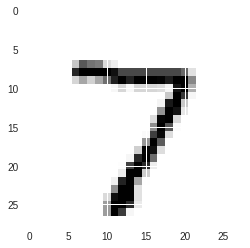

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(x_imagem_teste[0].reshape((28,28)))
